# Gaussian kernel Approximation
### In this code we approximate the Gaussian kernel of two graphs by the dot product of two k-random features consinus vectors, each belongs to the corresponding graph
### Datasets used: mutag, SBM or DD dataset
### Graph sampling technique used in this code: Simple Random Sampling, Random Walk With flyback, simple random walk sampling
### Machine learning algo: SVM with kernel

## This code can be uploaded on colab 

In [101]:
import grakel as gk
from grakel.utils import graph_from_networkx
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from grakel.datasets import fetch_dataset
from random import random
from grakel import Graph
from grakel.kernels import ShortestPath
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from grakel.kernels import GraphletSampling
import random

## The next two blocks are the graph_sampling class and the kernel_class 
### There is no code other than the classes' methods/attributes, so it is recommended that after compiling these two blocks, you go directly to next blocks and then go back when required

In [102]:
class graph_sampler:
    '''
    
    This class provides four sampling techniques:
    1. simple_random_sampling
    2. simple_random_walk_sampling
    3. random_walk_flyback_sampling
    4. random_walk_induced_graph_sampling
    
    Note that when initializing a new instance of this class, sampler_type should be the name of the
    required technique as specified above, except for simple_random_walk_sampling where sampler_type
    must be a tuple ("random_walk_flyback_sampling", p_flyback)
    
    After you initialize an instance, you can sample your Graph/list of Graphs by calling sample 
    method ( the last method)
    
    '''
    
    def __init__(self,sampler_type):
        if(type(sampler_type)==tuple): # ex: this is the case of random_walk_flyback (name, p_flyback)
            self.sampler_type=sampler_type[0]
            if(sampler_type[0]=="random_walk_flyback_sampling"):self.p_flyback=sampler_type[1]
        else : self.sampler_type=sampler_type
    
    def simple_sampling(self,G,nodes_num):     # one simple_random_sample of G
        return G.subgraph(random.sample(G.nodes(), nodes_num))

    def random_walk_sampling_simple(self,complete_graph, nodes_to_sample):  # also just one sample using this method
        T,growth_size=100,2  # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            curr_node = chosen_node
            iteration = iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                edges_before_t_iter = sampled_graph.number_of_edges()
        return sampled_graph
    
    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob): # returns one sample
        growth_size,T=2,100       # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                    print ("Choosing another random node to continue random walk ")
                edges_before_t_iter = sampled_graph.number_of_edges()

        return sampled_graph
    
    
    def random_walk_induced_graph_sampling(self, complete_graph, nodes_to_sample):
        growth_size,T=2,100       # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n
            
        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes - 1)

        Sampled_nodes = set([complete_graph.node[index_of_first_random_node]['id']])

        iteration = 1
        nodes_before_t_iter = 0
        curr_node = index_of_first_random_node
        while len(Sampled_nodes) != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            Sampled_nodes.add(complete_graph.node[chosen_node]['id'])
            curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((len(Sampled_nodes) - nodes_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes - 1)
                nodes_before_t_iter = len(Sampled_nodes)

        sampled_graph = complete_graph.subgraph(Sampled_nodes)

        return sampled_graph
    
    def sample(self,G, nodes_num, samples_num):
        for _ in range (samples_num):
            if self.sampler_type=="simple_random_sampling": sampled_subgraph=self.simple_sampling(G,nodes_num)
                
            elif self.sampler_type=="simple_random_walk_sampling":
                sampled_subgraph=self.random_walk_sampling_simple(G,nodes_num)

            elif self.sampler_type=="random_walk_flyback_sampling":
                sampled_subgraph=self.random_walk_sampling_with_fly_back(G,nodes_num,self.p_flyback)
                
            elif self.sampler_type=="random_walk_induced_graph_sampling":
                sampled_subgraph=self.random_walk_induced_graph_sampling(G,nodes_num)
          
            adjacency=nx.to_numpy_matrix(sampled_subgraph).flatten().T if _==0 \
                      else np.append(adjacency,nx.to_numpy_matrix(sampled_subgraph).flatten().T,axis=1)
        return adjacency
        

In [103]:
class Gaussian_random_features:
    
    '''
    This class affords an approximation of the Gaussian kernel using random features.
    When initializing a new instance, you should pass: 
    sigma: STD of the Gaussian kernel
    nodes_num: required size of the graphlets/subsamples
    features_num: number of random features
    sampler: an instance of graph_sampler class
    
    After initializing an instance, you can calc the kernel by calling calc_kernel method (the last one)
    '''
    
    def __init__(self, sigma, nodes_num, features_num, sampler):
        self.proj_mat=sigma*np.random.randn(features_num,nodes_num**2) 
        self.nodes_num=nodes_num
        self.features_num=features_num
        self.sampler=sampler
    
    def one_graph_random_features(self, G, samples_num):
        adjacency=self.sampler.sample(G,self.nodes_num, samples_num)
        temp = self.proj_mat.dot(adjacency)
        random_feature=np.concatenate((np.cos(temp),np.sin(temp)))
        return np.mean(random_feature,axis=1)
        
             
    def calc_random_features(self, Gnx, samples_num):
        for i in range(len(Gnx)):
            if i==0:
                random_features=self.one_graph_random_features(Gnx[i],samples_num)
            else:
                random_features=np.append(random_features,self.one_graph_random_features(Gnx[i], samples_num),axis=1)
        return random_features
    
    def calc_kernel(self, G_train, G_test, samples_num):
        random_features_train=self.calc_random_features(G_train,samples_num)
        random_features_test=self.calc_random_features(G_test,samples_num)
        K_train =random_features_train.T.dot(random_features_train)
        K_test =random_features_test.T.dot(random_features_train)
        return K_train, K_test
        




# Dataset loading
   ## Here you have three choices, so just compile the block which corresponds to your chosen dataset (mutag, SBM, DD). Or you can run the three blocks but make sure you run the wanted one last       :) ^_^

In [104]:
# mutag dataset
Gnx_train=[];
Gnx_test=[];
MUTAG = fetch_dataset("MUTAG", verbose=False,as_graphs=False)
G, y = MUTAG.data, MUTAG.target
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
for i in range(len(G_train)):
    g_current=nx.Graph(list(G_train[i][2]));
    g_current.add_nodes_from(G_train[i][1])
    Gnx_train.append(g_current)
for i in range(len(G_test)):
    g_current=nx.Graph(list(G_test[i][2]));
    g_current.add_nodes_from(G_test[i][1])
    Gnx_test.append(g_current)

here we plot to graphs from the two different classes in order to check the differences by a glince


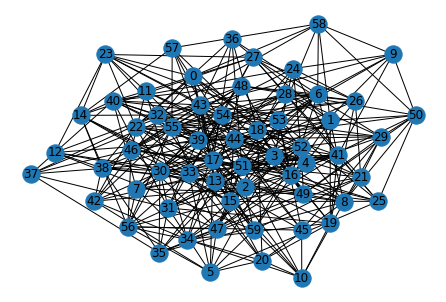

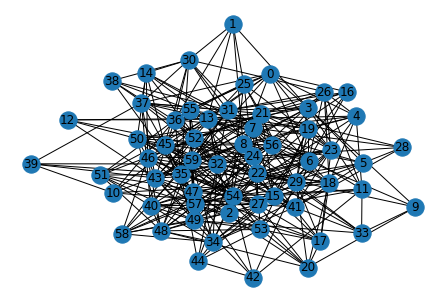

here we print the couple (p_in, p_out) for each of the two classes
first class (p_in,p_out)=  0.2833333333333333 0.19518518518518518
second class (p_in,p_out)=  0.425 0.1511111111111111


In [97]:
#SBM dataset generator
Graphs_num,nodes_per_graph,block_size=300,60,15
blocks_num=int(nodes_per_graph/block_size)
sizes=[block_size]*blocks_num
fraction=0.85;
avg_deg=fraction*block_size;                      # this degree should be the same in all the graphs
G,y=[],[]
for i in range (Graphs_num):                     ###########################################################
    #p_in=(fraction/3)*(1+i/(Graphs_num/2));
    p_in=fraction/3  if i <Graphs_num/2 else fraction*3/6
    p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
    #p_out=0 if i <Graphs_num/2 else 0
    p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
    G.append(nx.stochastic_block_model(sizes, p, seed=0))
    y.append(-1 if i<Graphs_num/2 else 1)
    #print(p_in,p_out)
    
# here we plot to graphs from the two different classes in order to check the differences by a glince
print("here we plot to graphs from the two different classes in order to check the differences by a glince")
nx.draw(G[0],with_labels=True)
plt.show()
nx.draw(G[Graphs_num-1],with_labels=True)
plt.show()
G, y = shuffle(G, y, random_state=0)

# here we print the couple (p_in, p_out) for each of the two classes
print("here we print the couple (p_in, p_out) for each of the two classes")
p_in=fraction/3      # first class
p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
print("first class (p_in,p_out)= ",p_in,p_out)
p_in=3/6*fraction
p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
print("second class (p_in,p_out)= ",p_in,p_out)

G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
Gnx_train,Gnx_test=G_train,G_test

In [99]:
# DD dataset
DD = fetch_dataset("DD", verbose=True)
G, y = DD.data, DD.target
Gnx_train=[];
Gnx_test=[];
Train_size=700                 # Taking just Train_size graphs of the data set as training set, 
                               #this is due to the large computatational time
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
G_train,y_train=G_train[0:Train_size], y_train[0:Train_size]
for i in range(len(G_train)):
    g_current=nx.Graph(list(G_train[i][0]));
    g_current.add_nodes_from(G_train[i][1])
    Gnx_train.append(g_current)
for i in range(len(G_test)):
    g_current=nx.Graph(list(G_test[i][0]));
    g_current.add_nodes_from(G_test[i][1])
    Gnx_test.append(g_current)


Extracting dataset  DD..
Parsing dataset  DD..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..




# The following part includes setting up the hyperparameters and conducting the learning process

In [105]:
nodes_num, features_num, samples_num, p_flyback, sigma= 6, 100 , 1000, 0.85, 10
sampler_type="simple_random_sampling"
sampler=graph_sampler(sampler_type);
Gauss_kernel=Gaussian_random_features(sigma, nodes_num, features_num, sampler)
K_train,K_test=Gauss_kernel.calc_kernel(Gnx_train, Gnx_test, samples_num)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print(y_pred)


Accuracy: 94.74%
[ 1  1 -1  1  1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1]


In [ ]:
# the solution: model selection
C_range = 10. ** np.arange(-2, 10)
param_grid = dict(C=C_range)
grid = GridSearchCV(SVC(kernel='precomputed', gamma='auto'),
                    param_grid=param_grid, cv=StratifiedKFold())
print('Fit...')
grid.fit(K_train, y_train)
# Training error
y_pred = grid.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print(y_pred)